In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')


In [325]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_submission = pd.read_csv('data/sample_submission.csv')

In [326]:
print(f'The Train dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns')
print(f'The Test dataset has {df_test.shape[0]} rows and {df_test.shape[1]} columns')

The Train dataset has 188533 rows and 13 columns
The Test dataset has 125690 rows and 12 columns


In [327]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [328]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [329]:
df_train['data_type'] = 'train'
df_test['data_type'] = 'test'
df = pd.concat([df_train, df_test], axis=0)

In [330]:
df.drop(columns=['id'], inplace=True)

## Dealing with fuel type and engine

In [331]:
df.fuel_type.isna().sum()

8466

In [332]:
df.fuel_type.value_counts()

fuel_type
Gasoline          276473
Hybrid             11508
E85 Flex Fuel       8929
Diesel              6641
–                   1319
Plug-In Hybrid       858
not supported         29
Name: count, dtype: int64

In [333]:
df.engine.isna().sum()

0

In [334]:
df.engine.value_counts().sort_values(ascending=False).head(5)

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel     5651
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel     4868
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel     4694
2.0L I4 16V GDI DOHC Turbo                       4513
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel    4090
Name: count, dtype: int64

### Extracting Horsepower, Engine Size, and Cylinder Count

In [335]:
import re

pattern_1 = r'(?:(\d{1,3}\.\d{1,3})HP)?\s*(\d{1,2}(?:\.\d{1,2})?)?\s*(?:L|\s*Liter)?\s*(?:[A-Za-z\s-]*)?(\d+)?\s*(?:V|I|Straight)?\s*(?:Cylinder)?'

# Apply regex for horsepower, engine size, and cylinder count
df[['horsepower', 'engine_size', 'cylinder_count']] = df['engine'].str.extract(pattern_1)

# Convert numeric fields to appropriate data types
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df['engine_size'] = pd.to_numeric(df['engine_size'], errors='coerce')
df['cylinder_count'] = pd.to_numeric(df['cylinder_count'], errors='coerce')

In [336]:
print("Horsepower NaN Count: ", df.horsepower.isna().sum())
print("Engine Size NaN Count: ", df.engine_size.isna().sum())
print("Cylinder Count NaN Count: ", df.cylinder_count.isna().sum())

Horsepower NaN Count:  55502
Engine Size NaN Count:  11113
Cylinder Count NaN Count:  23427


### Extracting Fuel Type

In [337]:
# Regex pattern for fuel type
pattern_2 = r'(Electric Motor|Electric Fuel System|Electric|Gasoline|Diesel|Flex Fuel|Plug-In Electric/Gas|Plug-In Electric|Plug-In Hybrid|Hybrid.*|Gas/Electric Hybrid)'

# Apply regex for fuel type
df['engine_fuel_type'] = df['engine'].str.extract(pattern_2)

# Check the result
print(df['engine_fuel_type'].value_counts(dropna=False))

engine_fuel_type
Gasoline                233024
NaN                      52561
Flex Fuel                 8551
Electric Motor            8230
Diesel                    6889
Gas/Electric Hybrid       2565
Plug-In Electric/Gas       893
Electric                   826
Hybrid                     684
Name: count, dtype: int64


In [338]:
df['engine_fuel_type'] = df['engine_fuel_type'].replace({
    'Electric Motor': 'Electric',
    'Plug-In Electric': 'Electric',
    'Gas/Electric Hybrid': 'Hybrid',
    'Plug-In Electric/Gas': 'Plug-In Hybrid',
    'Flex Fuel': 'Flex',
})
df.engine_fuel_type.value_counts()

engine_fuel_type
Gasoline          233024
Electric            9056
Flex                8551
Diesel              6889
Hybrid              3249
Plug-In Hybrid       893
Name: count, dtype: int64

In [339]:
df.fuel_type.value_counts()

fuel_type
Gasoline          276473
Hybrid             11508
E85 Flex Fuel       8929
Diesel              6641
–                   1319
Plug-In Hybrid       858
not supported         29
Name: count, dtype: int64

In [340]:
df['fuel_type'] = df['fuel_type'].replace({
    'E85 Flex Fuel': 'Flex',
    'not supported': np.nan,
    '–': np.nan
})
df.fuel_type.value_counts(dropna=False)

fuel_type
Gasoline          276473
Hybrid             11508
NaN                 9814
Flex                8929
Diesel              6641
Plug-In Hybrid       858
Name: count, dtype: int64

### Filling NaN values in fuel_type with engine_fuel_type

In [341]:
df.loc[df.fuel_type.isna(), 'fuel_type'] = df.loc[df.fuel_type.isna(), 'engine_fuel_type']
df.fuel_type.value_counts(dropna=False)

fuel_type
Gasoline          276587
Hybrid             11512
Flex                8932
Electric            8099
Diesel              6646
NaN                 1588
Plug-In Hybrid       859
Name: count, dtype: int64

## Ext and Int colors

In [342]:
df.ext_col.value_counts(dropna=False)

ext_col
Black                                      81028
White                                      73040
Gray                                       42193
Silver                                     28343
Blue                                       24272
Red                                        16548
Green                                       4556
Gold                                        2838
Brown                                       1920
Orange                                      1896
Beige                                       1820
Yellow                                      1603
Bright White Clearcoat                      1263
Diamond Black                               1170
Agate Black Metallic                        1056
Summit White                                 852
Silver Ice Metallic                          738
Mythos Black Metallic                        697
Midnight Black Metallic                      641
Granite Crystal Clearcoat Metallic           602
–           

In [343]:
df.ext_col = df.ext_col.apply(lambda x: x.lower())
df.int_col = df.int_col.apply(lambda x: x.lower())

In [344]:
elementary_colors = ['black', 'gray', 'grey', 'silver', 'white', 'red', 'blue', 'brown', 'yellow', 'green', 'orange', 'pink', 'purple']

def map_to_elementary_color(color_name):
    color_name_lower = color_name.lower()
    for color in elementary_colors:
        if color in color_name_lower:
            return color 
    return 'other'

df['ext_col'] = df['ext_col'].apply(map_to_elementary_color)
df['int_col'] = df['int_col'].apply(map_to_elementary_color)

## Clean title

In [345]:
df.clean_title.value_counts(dropna=False)

clean_title
Yes    278565
NaN     35658
Name: count, dtype: int64

In [346]:
df['clean_title'] = df['clean_title'].replace({
    np.nan: 'No'
})
df.clean_title.value_counts(dropna=False)

clean_title
Yes    278565
No      35658
Name: count, dtype: int64

## Accident

In [347]:
df.accident.value_counts(dropna=False)

accident
None reported                             240777
At least 1 accident or damage reported     69362
NaN                                         4084
Name: count, dtype: int64

In [348]:
df['accident'] = df['accident'].replace({
    np.nan: 'None reported',
})
df.accident.value_counts(dropna=False)

accident
None reported                             244861
At least 1 accident or damage reported     69362
Name: count, dtype: int64

## Model year

In [349]:
df.model_year.isna().sum()

0

### Creating a new feature: age_of_car

In [350]:
df['age_of_car'] = df['model_year'].apply(lambda x: datetime.now().year - x).astype(int)
print(df.age_of_car.describe())

count   314223.000
mean         8.183
std          5.666
min          0.000
25%          4.000
50%          7.000
75%         11.000
max         50.000
Name: age_of_car, dtype: float64


## Transmission

In [351]:
df.transmission.value_counts(dropna=False)

transmission
A/T                                                   83036
8-Speed A/T                                           34586
Transmission w/Dual Shift Mode                        32079
6-Speed A/T                                           30105
6-Speed M/T                                           19863
7-Speed A/T                                           18498
Automatic                                             17866
8-Speed Automatic                                     13977
10-Speed A/T                                          13347
9-Speed A/T                                            6450
5-Speed A/T                                            5458
10-Speed Automatic                                     5268
6-Speed Automatic                                      4690
4-Speed A/T                                            4212
5-Speed M/T                                            4048
9-Speed Automatic                                      3878
CVT Transmission           

In [352]:
df['transmission'] = df['transmission'].str.lower()

### Extracting Transmission Type, Gear Count, Gear Control Type and Special Features

In [353]:
pattern = r'(?:(\d+|single)-speed)?\s*(a/t|automatic|m/t|manual|cvt|dct|electronically controlled)?(?:.*?(auto-shift|overdrive|dual shift mode))?'
pattern = r'(?:(\d+|single)-speed)?\s*(a/t|automatic|m/t|manual|cvt|dct|electronically controlled|at/mt)?(?:.*?(auto-shift|overdrive|dual shift mode))?'
pattern = r'(?:(\d+|single)[-\s]speed)?\s*(a[/]?t|automatic|m[/]?t|manual|cvt|dct|electronically controlled|at/mt)?(?:.*?(auto-shift|overdrive|dual shift mode))?'

# Apply the regex pattern to extract the columns
df[['gear_count', 'transmission_type', 'special_features']] = df['transmission'].str.extract(pattern)

# Handle the gear_control_type based on the extracted transmission_type
df['gear_control_type'] = df['transmission_type'].apply(lambda x: 'variable' if 'cvt' in str(x) else 'fixed')

# Fill missing special_features with 'standard' as the default
df['special_features'] = df['special_features'].fillna('standard')

In [354]:
print("Gear Count NaN Count: ", df.gear_count.isna().sum())
print("Transmission Type NaN Count: ", df.transmission_type.isna().sum())
print("Special Features NaN Count: ", df.special_features.isna().sum())
print("Gear Control Type NaN Count: ", df.gear_control_type.isna().sum())

Gear Count NaN Count:  140478
Transmission Type NaN Count:  33006
Special Features NaN Count:  0
Gear Control Type NaN Count:  0


In [355]:
df.transmission_type.value_counts(dropna=False)

transmission_type
a/t                          198983
automatic                     51526
NaN                           33006
m/t                           26466
cvt                            3354
manual                          677
mt                               66
electronically controlled        60
at                               56
dct                              29
Name: count, dtype: int64

In [356]:
df['transmission_type'] = df['transmission_type'].replace({
    'mt': 'manual',
    'm/t': 'manual',
    'at': 'automatic',
    'a/t': 'automatic',
    'dct': 'automatic',
    'cvt': 'automatic',
    'electronically controlled': 'automatic',
})
df.transmission_type.value_counts(dropna=False)

transmission_type
automatic    254008
NaN           33006
manual        27209
Name: count, dtype: int64

In [357]:
df.gear_count.value_counts(dropna=False)

gear_count
NaN       140478
6          55373
8          49545
7          21714
10         18694
9          10389
5           9796
4           4295
1           3760
2            151
single        28
Name: count, dtype: int64

In [358]:
df['gear_count'] = df['gear_count'].replace({
    'single': 1
})
df.gear_count.value_counts(dropna=False)

gear_count
NaN    140478
6       55373
8       49545
7       21714
10      18694
9       10389
5        9796
4        4295
1        3760
2         151
1          28
Name: count, dtype: int64

In [359]:
df.special_features.value_counts(dropna=False)

special_features
standard           278685
dual shift mode     32079
auto-shift           3100
overdrive             359
Name: count, dtype: int64

In [360]:
df.gear_control_type.value_counts(dropna=False)

gear_control_type
fixed       310869
variable      3354
Name: count, dtype: int64

## Missing Data

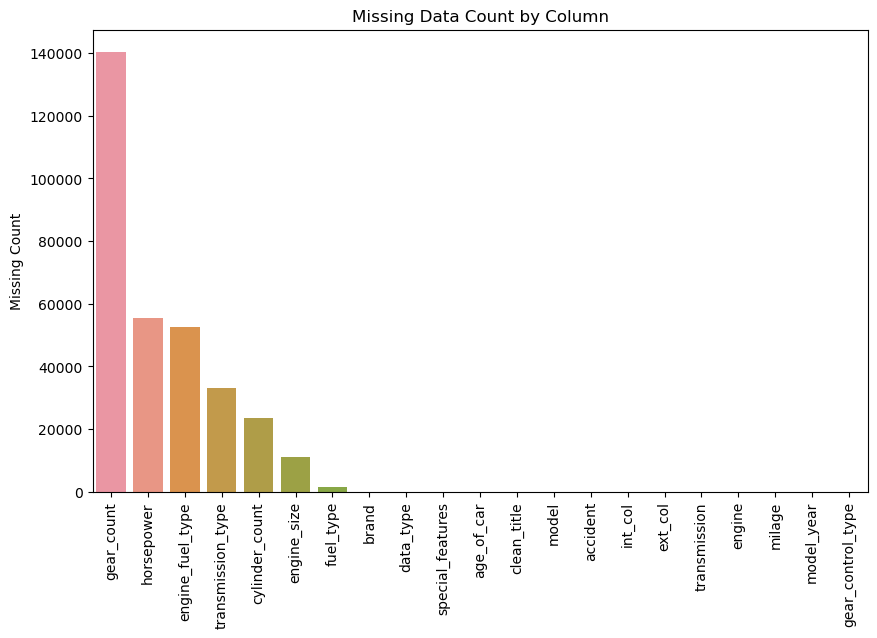

In [361]:
missing_data = df.drop(columns=['price']).isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=missing_data.index, y=missing_data.values)
plt.xticks(rotation=90)
plt.title('Missing Data Count by Column')
plt.ylabel('Missing Count')
plt.show()

### Adding binary indicators for missing data

In [362]:
df['gear_count_missing'] = df['gear_count'].isnull().astype(int)
df['horsepower_missing'] = df['horsepower'].isnull().astype(int)
df['fuel_type_missing'] = df['fuel_type'].isnull().astype(int)

## Price

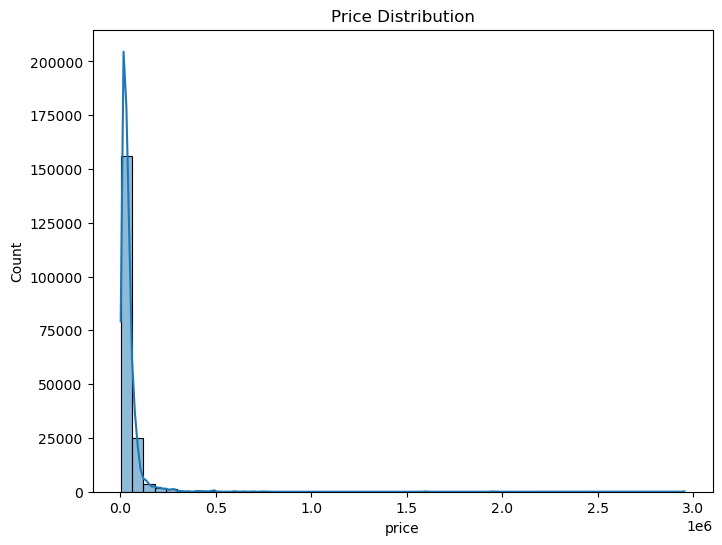

In [363]:
plt.figure(figsize=(8,6))
sns.histplot(df_train['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.show()

### Log-transforming the price

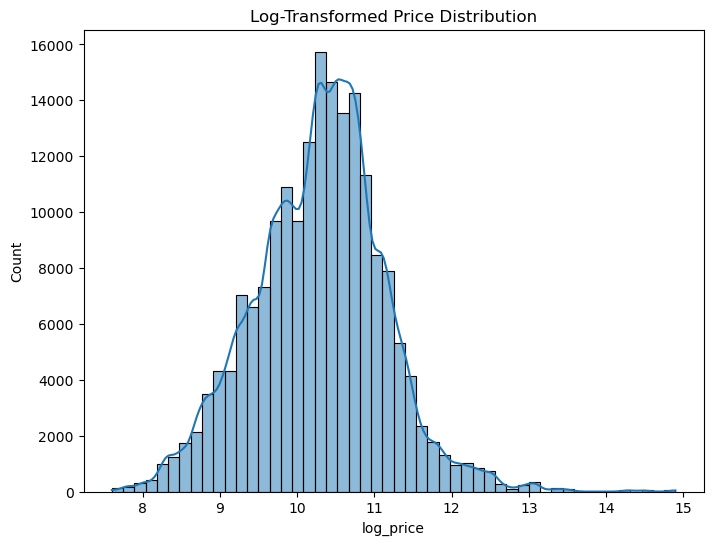

In [364]:
# If the distribution is highly skewed, you can try log-transforming the price
df.loc[df['data_type'] == 'train', 'log_price'] = np.log1p(df.loc[df['data_type'] == 'train', 'price'])

# Visualize the transformed price distribution
plt.figure(figsize=(8,6))
sns.histplot(df.loc[df['data_type'] == 'train', 'log_price'], bins=50, kde=True)
plt.title('Log-Transformed Price Distribution')
plt.show()

## Milage

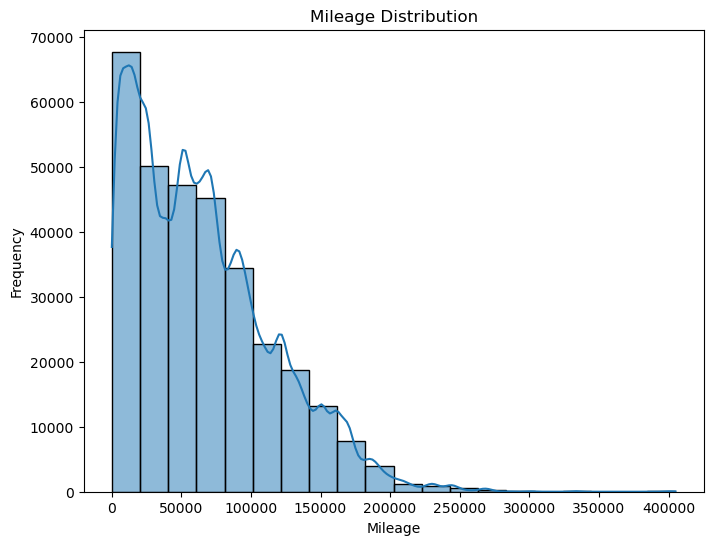

In [365]:
df['milage'] = pd.to_numeric(df['milage'], errors='coerce')

# Plot the distribution of mileage
plt.figure(figsize=(8,6))
sns.histplot(df['milage'], bins=20, kde=True)
plt.title('Mileage Distribution')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

### Normalizing Milage Data

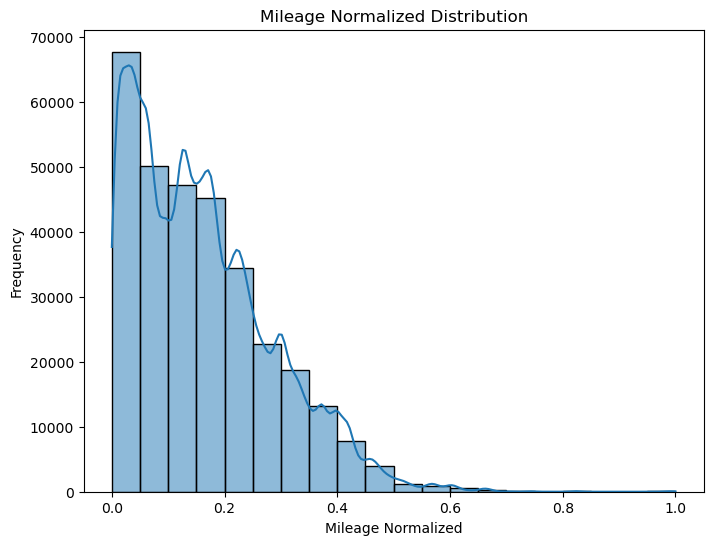

In [366]:
from sklearn.preprocessing import MinMaxScaler

# Assume df is your DataFrame and 'milage' is the column you want to normalize
scaler = MinMaxScaler()

# Reshape the data if you are working with a single column
df['milage_normalized'] = scaler.fit_transform(df[['milage']])

# Plot the distribution of mileage_normalized
plt.figure(figsize=(8,6))
sns.histplot(df['milage_normalized'], bins=20, kde=True)
plt.title('Mileage Normalized Distribution')
plt.xlabel('Mileage Normalized')
plt.ylabel('Frequency')
plt.show()

## Encode categorical variables

In [367]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
for column in categorical_columns:
    print(column)

brand
model
fuel_type
engine
transmission
ext_col
int_col
accident
clean_title
data_type
engine_fuel_type
gear_count
transmission_type
special_features
gear_control_type


In [368]:
df.drop(columns=['engine', 'transmission'], inplace=True)

In [369]:
df['clean_title'] = df['clean_title'].map({'No': 0, 'Yes': 1}).astype(int)
df.clean_title.value_counts()

clean_title
1    278565
0     35658
Name: count, dtype: int64

### Target encoding for categorical variables

In [370]:
import category_encoders as ce

# List of categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns.remove('data_type')

# Step 1: Apply target encoding only on the training data
encoder = ce.TargetEncoder(cols=categorical_columns, smoothing=0.2)

# Fit the encoder on the training data (where log_price is available)
encoder.fit(df[df['data_type'] == 'train'][categorical_columns], df[df['data_type'] == 'train']['log_price'])

# Step 2: Transform both training and test data using the fitted encoder
df_encoded = encoder.transform(df[categorical_columns])

# Add the target-encoded columns back into the main DataFrame with new column names
for col in categorical_columns:
    df[col + '_target_encoded'] = df_encoded[col]

#### Handle Missing Encodings in Test Data

In [371]:
# Calculate the global mean of log_price from the training data
global_mean = df[df['data_type'] == 'train']['log_price'].mean()

# Fill missing values in target-encoded columns with the global mean of log_price (for unseen categories in the test set)
for col in categorical_columns:
    df[col + '_target_encoded'].fillna(global_mean, inplace=True)

## Training Models on Train Data

#### Split the concatenated DataFrame back into train and test sets

In [372]:
# Split the concatenated DataFrame back into train and test sets
df_train_encoded = df[df['data_type'] == 'train'].drop(columns=['data_type'])
df_test_encoded = df[df['data_type'] == 'test'].drop(columns=['data_type', 'log_price', 'price'])  # Test set has no price

#### Stratified K-Fold Cross-Validation on Training Data

In [373]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Define the number of splits for K-Fold
n_splits = 5

# Bin the log_price for stratified K-Fold cross-validation
df_train_encoded['log_price_bin'] = pd.qcut(df_train_encoded['log_price'], q=n_splits, labels=False)

# Initialize Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare the features and target
X = df_train_encoded.drop(columns=categorical_columns + ['price', 'log_price', 'log_price_bin'])  # Features
y = df_train_encoded['log_price']  # Log-transformed target

# Loop through each fold in Stratified K-Fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X, df_train_encoded['log_price_bin'])):
    print(f"Training fold {fold+1}")
    
    # Split the data into training and validation sets for this fold
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train the model on the current fold's training data
    model = lgb.LGBMRegressor()
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_val_pred = model.predict(X_val)
    
    # Reverse log transformation for the validation predictions and true values
    y_val_true = np.expm1(y_val)
    y_val_pred_original_scale = np.expm1(y_val_pred)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred_original_scale))
    print(f"Fold {fold+1} RMSE: {rmse}")

Training fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1266
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 22
[LightGBM] [Info] Start training from score 10.291930
Fold 1 RMSE: 72685.1183199675
Training fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1265
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 22
[LightGBM] [Info] Start training from score 10.291668
Fold 2 RMSE: 71296.14393385565
Training fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of t

#### Train Final Model on Full Training Data

In [374]:
# Train on the full training data
X_full = df_train_encoded.drop(columns=categorical_columns + ['price', 'log_price', 'log_price_bin'])  # Features
y_full = df_train_encoded['log_price']

# Train the final model
model = lgb.LGBMRegressor()
model.fit(X_full, y_full)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1266
[LightGBM] [Info] Number of data points in the train set: 188533, number of used features: 22
[LightGBM] [Info] Start training from score 10.291787


LGBMRegressor()

## Predict and Submit

In [375]:
# Make sure the test set has the same features as the training set
X_full = df_train_encoded.drop(columns=categorical_columns + ['price', 'log_price', 'log_price_bin'])  # These are the features you used for training

# Get the same feature set from the test set
df_test_features = df_test_encoded[X_full.columns]  # Select only the columns that were used for training

# Make predictions on the test data using the same features
predictions_log_scale = model.predict(df_test_features)

# Reverse the log transformation to get the actual price predictions
predictions_original_scale = np.expm1(predictions_log_scale)

# Create the submission DataFrame with 'id' and 'price'
df_submission = pd.DataFrame({
    'id': df_test['id'],
    'price': predictions_original_scale
})

# Step 4: Save the submission DataFrame to a CSV file
df_submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")

Submission file created successfully.
